## Text Classification

In [2]:
import pandas as pd

df = pd.read_csv("Datasets/Fake_Real_Data.csv", encoding="latin1")

print(df.shape)
df.head(5)

(9900, 2)


,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [3]:
#check the distribution of labels
df['label'].value_counts()

,count
label,
Fake,5000
Real,4900


#### Convert label column to num (0,1)

In [5]:
df['label_num'] = df['label'].map({'Fake' : 0, 'Real': 1})

In [6]:
df.head(5)

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


#### Get spacy word vectors and store them in a pandas dataframe

In [8]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 3.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [9]:
import spacy

nlp = spacy.load("en_core_web_lg")

In [10]:
df['vector'] = df['Text'].apply(lambda text: nlp(text).vector)

In [11]:
df.head()

,Text,label,label_num,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0,"[-0.10024771, 0.17778867, -0.119053714, -0.036..."
1,U.S. conservative leader optimistic of common ...,Real,1,"[-0.0060389177, 0.16344602, -0.051333923, 0.02..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1,"[-0.122386694, 0.16912815, -0.021297095, -0.06..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0,"[-0.027337318, 0.12501417, -0.0073965387, -0.0..."
4,Democrats say Trump agrees to work on immigrat...,Real,1,"[-0.028613936, 0.09241263, -0.028202401, -0.00..."


#### train_test_split

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.label_num,
    test_size=0.2,
    random_state=2022
)

In [13]:
X_train.shape

(7920,)

In [14]:
import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [15]:
X_train_2d.shape

(7920, 300)

#### MultinomialNB

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)

MultinomialNB()

In [21]:
from sklearn.metrics import classification_report
y_pred = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1024
           1       0.95      0.95      0.95       956

    accuracy                           0.96      1980
   macro avg       0.95      0.96      0.95      1980
weighted avg       0.96      0.96      0.96      1980



MultinomialNB model performed well but did not come into the top list because in the 300-dimensional vectors we also have the negative values present. The Naive Bayes model does not fit the data if there are negative values. So, to overcome this shortcoming, we have used the Min-Max scaler to bring down all the values between 0 to 1. In this process, there will be a possibility of variance and information loss among the data. But anyhow we got a decent recall and f1 scores.

#### KNeighborsClassifier (KNN)

In [24]:
from  sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

clf.fit(X_train_2d, y_train)

y_pred = clf.predict(X_test_2d)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1024
           1       0.96      0.98      0.97       956

    accuracy                           0.97      1980
   macro avg       0.97      0.97      0.97      1980
weighted avg       0.97      0.97      0.97      1980



KNN model performed really well with glove vectors due to only 300-dimensional vectors and very good embeddings(similar and related words have almost similar embeddings) for the given text data.

#### Confusion Matrix

Text(95.72222222222221, 0.5, 'Truth')

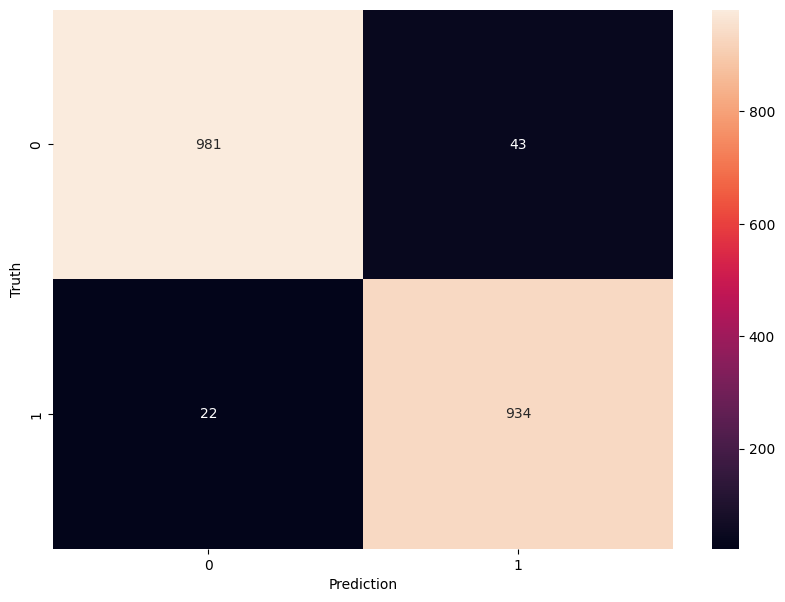

In [25]:
#finally print the confusion matrix for the best model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')